In [1]:
import pandas as pd
import numpy as np
import random
from numpy.matlib import repmat
import scipy.io as io
import matplotlib.pyplot as plt

In [2]:
attributes = ['area', 'perimeter', 'compactnes', 'length of kernel', 'width of kernel', 'asymmetry coefficient',
              'length of kernel groove', 'class']
df = pd.read_csv('seeds_dataset.txt', sep="\t", header=None, names=attributes)
df[: 5]

,area,perimeter,compactnes,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
X = df.values[:, :7]
y = np.array(df.values[:, 7], dtype=int)

# Considering minimum correlated attributes
X = X[:, [2, 5, 6]]
print ('size of data matrix X ='), X.shape
print ('size of labels y ='), y.shape

size of data matrix X = (210, 3)
size of labels y = (210,)


In [64]:
# Dividing the data randomly into 80% train 
# and 20% test samples.
sam = X.shape[0]
num = int(0.8*sam)
indcs = range(sam)
random.shuffle(indcs)
train_indcs = indcs[:num]
test_indcs = indcs[num:]
X_train, X_test = X[train_indcs, :], X[test_indcs, :]
y_train, y_test = y[train_indcs], y[test_indcs]

print 'Training data size =', X_train.shape
print 'Training labels size =', y_train.shape
print 'Testing data size =', X_test.shape
print 'Testing labels size =', y_test.shape

#io.savemat('p2_custom_data.mat', mdict={'train_data': X_train,
#                                        'train_labels': y_train,
#                                        'test_data': X_test,
#                                        'test_labels': y_test
#                                       })

Training data size = (168, 7)
Training labels size = (168,)
Testing data size = (42, 7)
Testing labels size = (42,)


In [4]:
data = io.loadmat('p2_used_data.mat')
X_train = data['train_data'] 
y_train = data['train_labels'].reshape((X_train.shape[0],))
X_test = data['test_data']
y_test = data['test_labels'].reshape((X_test.shape[0],))

X_train = X_train[:, [2,5,6]]
X_test = X_test[:, [2,5,6]]

print 'Training data size =', X_train.shape
print 'Training labels size =', y_train.shape
print 'Testing data size =', X_test.shape
print 'Testing labels size =', y_test.shape

Training data size = (168, 3)
Training labels size = (168,)
Testing data size = (42, 3)
Testing labels size = (42,)


In [5]:
print 'Training Data: Class 1 %d, Class 2 %d, Class 3 %d' % (np.sum(y_train==1), np.sum(y_train==2), np.sum(y_train==3))
print 'Testing Data: Class 1 %d, Class 2 %d, Class 3 %d' % (np.sum(y_test==1), np.sum(y_test==2), np.sum(y_test==3))

Training Data: Class 1 55, Class 2 55, Class 3 58
Testing Data: Class 1 15, Class 2 15, Class 3 12


In [7]:
from sklearn.cluster import KMeans
from scipy import stats

max_clusters = 10
train_errors = []
test_errors = []
min_test_error = 100
for K in range(3, 3+max_clusters):
    cluster_labels = np.zeros((K, ), dtype=int)
    kmeans = KMeans(n_clusters=K, random_state=0, max_iter=1000).fit(X_train)
    train_closest = kmeans.predict(X_train)

    for k in range(K):
        cluster_labels[k] = stats.mode(y_train[train_closest == k])[0][0]

    # Prediction on training data
    y_train_pred = cluster_labels[train_closest]
    train_error = 100*(1 - np.mean(y_train_pred == y_train))
    train_errors.append(train_error)

    # Training error
    # Prediction on test data
    test_closest = kmeans.predict(X_test)
    y_test_pred = cluster_labels[test_closest]
    # Test Error
    test_error = 100*(1 - np.mean(y_test_pred == y_test))
    test_errors.append(test_error)
    # Checking for minimum
    if test_error < min_test_error:
        min_test_error = test_error
        min_protypes = K

print ('Minimum classification error on the training set = %.2f%%') % (min(train_errors))
print ('Minimum classification error on the testing set = %.2f%%') % (min(test_errors))

Minimum classification error on the training set = 14.88%
Minimum classification error on the testing set = 9.52%


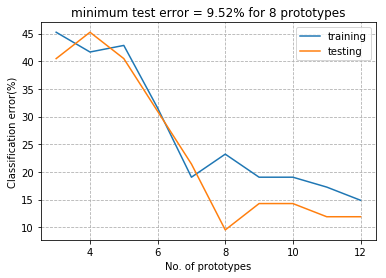

In [8]:
plt.plot(range(3, 3+max_clusters), train_errors, range(3, 3+max_clusters), test_errors)
plt.legend(['training', 'testing'])
plt.xlabel('No. of prototypes')
plt.ylabel('Classification error(%)')
plt.grid(linestyle='--')
s = 'minimum test error = ' + r'%.2f%%' % min_test_error + ' for ' + str(min_protypes) + ' prototypes'
plt.title(s)
#plt.savefig('p2_errorVsPrototypes.jpg', dpi=300)
plt.show()

In [15]:
################# CROSS VALIDATION ##################
from sklearn.model_selection import KFold
no_folds = 10
max_clusters = 10
kf = KFold(n_splits = no_folds)

train_errors = np.zeros((no_folds, max_clusters))
test_errors = np.zeros((no_folds, max_clusters))

fold = 0
for train, test in kf.split(X):
    for K in range(3, 3+max_clusters):
    # Train and Test data
        X_train_v, y_train_v = X[train], y[train]
        X_test_v, y_test_v = X[test], y[test]
    # Applying K-means
        cluster_labels = np.zeros((K, ), dtype=int)
        kmeans = KMeans(n_clusters=K, random_state=0, max_iter=1000).fit(X_train_v)
        train_closest = kmeans.predict(X_train_v)

        for k in range(K):
            cluster_labels[k] = stats.mode(y_train_v[train_closest == k])[0][0]

        # Prediction on training data
        y_train_pred = cluster_labels[train_closest]
        train_error = 100*(1 - np.mean(y_train_pred == y_train_v))
        train_errors[fold, K-3] = train_error

        # Training error
        # Prediction on test data
        test_closest = kmeans.predict(X_test_v)
        y_test_pred = cluster_labels[test_closest]
        # Test Error
        test_error = 100*(1 - np.mean(y_test_pred == y_test_v))
        test_errors[fold, K-3] = test_error
    fold += 1

# Calculating the mean and standard deviation
train_errors_mean = np.mean(train_errors, axis=0)
train_errors_std = np.std(train_errors, axis=0)
test_errors_mean = np.mean(test_errors, axis=0)
test_errors_std = np.std(test_errors, axis=0) 

In [16]:
train_errors_mean.shape, train_errors_std.shape
print train_errors_mean[5]
print test_errors_mean[8]
print ('Minimum cross validation error on the training set = %.2f%% for %d prototypes') % (min(train_errors_mean), np.argmin(train_errors_mean))
print ('Maximum cross validation error on the testing set = %.2f%% for %d prototypes') % (min(test_errors_mean), np.argmin(test_errors_mean))

18.3068783069
21.4285714286
Minimum cross validation error on the training set = 16.56% for 8 prototypes
Maximum cross validation error on the testing set = 14.29% for 5 prototypes


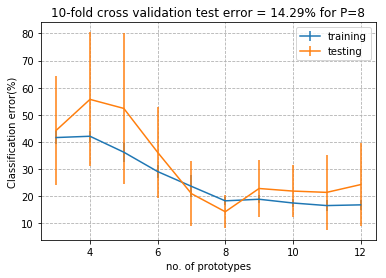

In [17]:
plt.errorbar(range(3, 3+max_clusters), train_errors_mean, train_errors_std)
plt.errorbar(range(3, 3+max_clusters), test_errors_mean, test_errors_std)
plt.legend(['training', 'testing'])
plt.xlabel('no. of prototypes')
plt.ylabel('Classification error(%)')
plt.grid(linestyle='--')
s = '10-fold cross validation test error = ' + r'%.2f%%' % min(test_errors_mean) + ' for P='+ \
    str(3+np.argmin(test_errors_mean))
plt.title(s)
#plt.savefig('p2_errorVsPrototypes_crossValid.jpg', dpi=300)
plt.show()

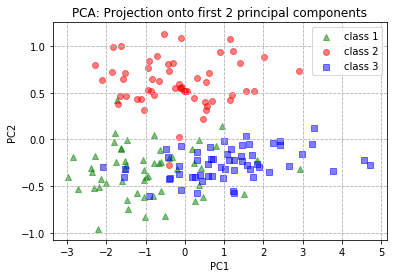

In [7]:
################### Dimension Reduction #######################
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca = pca.transform(X_train)

for label,marker,color in zip(range(1,4),('^', 'o', 's'),('green', 'red', 'blue')):
    plt.scatter(x=X_train_pca[:,0].real[y_train == label],
                y=X_train_pca[:,1].real[y_train == label],
                marker=marker,
                color=color,
                alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Projection onto first 2 principal components')
plt.legend(['class 1', 'class 2', 'class 3'])
plt.grid(linestyle='--')
plt.show()

In [22]:
from sklearn.cluster import KMeans
from scipy import stats

max_clusters = 10
train_errors = []
test_errors = []
min_test_error = 100
for K in range(3, 3+max_clusters):
    cluster_labels = np.zeros((K, ), dtype=int)
    kmeans = KMeans(n_clusters=K, random_state=0, max_iter=1000).fit(X_train_pca)
    train_closest = kmeans.predict(X_train_pca)

    for k in range(K):
        cluster_labels[k] = stats.mode(y_train[train_closest == k])[0][0]

    # Prediction on training data
    y_train_pred = cluster_labels[train_closest]
    train_error = 100*(1 - np.mean(y_train_pred == y_train))
    train_errors.append(train_error)

    # Training error
    # Prediction on test data
    test_closest = kmeans.predict(X_test_pca)
    y_test_pred = cluster_labels[test_closest]
    # Test Error
    test_error = 100*(1 - np.mean(y_test_pred == y_test))
    test_errors.append(test_error)
    # Checking for minimum
    if test_error < min_test_error:
        min_test_error = test_error
        min_protypes = K

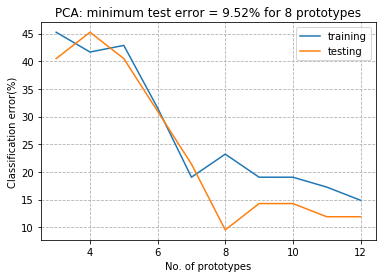

In [23]:
plt.plot(range(3, 3+max_clusters), train_errors, range(3, 3+max_clusters), test_errors)
plt.legend(['training', 'testing'])
plt.xlabel('No. of prototypes')
plt.ylabel('Classification error(%)')
plt.grid(linestyle='--')
s = 'PCA: minimum test error = ' + r'%.2f%%' % min_test_error + ' for ' + str(min_protypes) + ' prototypes'
plt.title(s)
#plt.savefig('p2_errorVsPrototypes_redPCA.jpg', dpi=300)
plt.show()

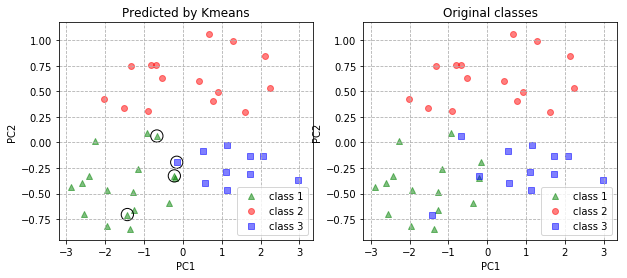

In [24]:
K = 8
cluster_labels = np.zeros((K, ), dtype=int)
kmeans = KMeans(n_clusters=K, random_state=0, max_iter=1000).fit(X_train_pca)
train_closest = kmeans.predict(X_train_pca)

for k in range(K):
    cluster_labels[k] = stats.mode(y_train[train_closest == k])[0][0]

# Prediction on training data
y_train_pred = cluster_labels[train_closest]
train_error = 100*(1 - np.mean(y_train_pred == y_train))

# Training error
# Prediction on test data
test_closest = kmeans.predict(X_test_pca)
y_test_pred = cluster_labels[test_closest]
# Test Error
test_error = 100*(1 - np.mean(y_test_pred == y_test))

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
for label,marker,color in zip(range(1,4),('^', 'o', 's'),('green', 'red', 'blue')):
    plt.scatter(x=X_test_pca[:,0].real[y_test_pred == label],
                y=X_test_pca[:,1].real[y_test_pred == label],
                marker=marker,
                color=color,
                alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Predicted by Kmeans')
plt.legend(['class 1', 'class 2', 'class 3'])
plt.grid(linestyle='--')
plt.scatter(X_test_pca[:, 0].real[y_test_pred != y_test],
            X_test_pca[:, 1].real[y_test_pred != y_test], s = 150, facecolors = 'none', edgecolors = 'k')

plt.subplot(1, 2, 2)
for label,marker,color in zip(range(1,4),('^', 'o', 's'),('green', 'red', 'blue')):
    plt.scatter(x=X_test_pca[:,0].real[y_test == label],
                y=X_test_pca[:,1].real[y_test == label],
                marker=marker,
                color=color,
                alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Original classes')
plt.legend(['class 1', 'class 2', 'class 3'])
plt.grid(linestyle='--')
#plt.savefig('p2_Kmeans_scatterPlot_PCA.jpg', dpi=300)
plt.show()

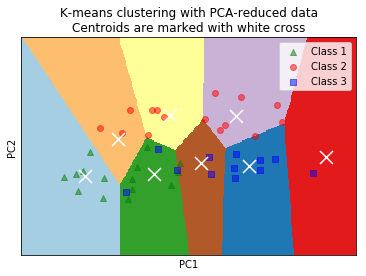

In [32]:
################# K-means Clusters Visualization #######################

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

#plt.plot(X_test_pca[:, 0], X_test_pca[:, 1], 'k.', markersize=2)
for label,marker,color in zip(range(1,4),('^', 'o', 's'),('green', 'red', 'blue')):
    plt.scatter(x=X_test_pca[:,0].real[y_test == label],
                y=X_test_pca[:,1].real[y_test == label],
                marker=marker,
                color=color,
                alpha=0.5)
plt.legend(['Class 1', 'Class 2', 'Class 3'])
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering with PCA-reduced data\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('p2_KMeans_Cluster_Visualization.jpg', dpi = 300)
plt.show()

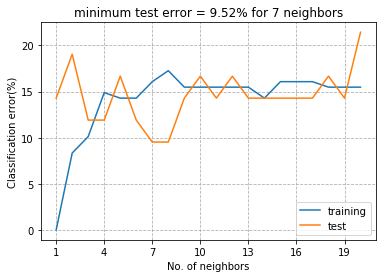

Minimum cross validation error on the training set = 0.00% for 8 clusters
Maximum cross validation error on the testing set = 9.52% for 5 clusters


In [19]:
##################### K-Nearest Neighbours ######################
from sklearn import neighbors

train_errors = []
test_errors = []

max_neighbors = 20

for n_neighbors in range(max_neighbors):
    clf = neighbors.KNeighborsClassifier(1+n_neighbors)
    clf.fit(X_train, y_train)

    # Training error
    y_train_pred = clf.predict(X_train)
    train_error = 100*(1 - np.mean(y_train_pred == y_train))
    train_errors.append(train_error)
    # Test error
    y_test_pred = clf.predict(X_test)
    test_error = 100*(1 - np.mean(y_test_pred == y_test))
    test_errors.append(test_error)

plt.plot(range(1,1+max_neighbors), train_errors)
plt.plot(range(1, 1+max_neighbors), test_errors)
plt.legend(['training', 'test'])
plt.xlabel('No. of neighbors')
plt.ylabel('Classification error(%)')
plt.xticks(range(1, 1+max_neighbors, 3))
plt.grid(linestyle='--')
s = 'minimum test error = ' + r'%.2f%%' % min(test_errors) + ' for ' + str(1+np.argmin(test_errors)) + ' neighbors'
plt.title(s)
#plt.savefig('p2_errorVsNeighbors.jpg', dpi=300)
plt.show()

print ('Minimum cross validation error on the training set = %.2f%% for %d clusters') % (min(train_errors), np.argmin(train_errors_mean))
print ('Maximum cross validation error on the testing set = %.2f%% for %d clusters') % (min(test_errors), np.argmin(test_errors_mean))

In [54]:
################# CROSS VALIDATION ##################
from sklearn.model_selection import KFold
no_folds = 10
max_neighbors = 20
kf = KFold(n_splits = no_folds)

train_errors = np.zeros((no_folds, max_neighbors))
test_errors = np.zeros((no_folds, max_neighbors))

fold = 0
for train, test in kf.split(X):
    for n_neighbors in range(max_neighbors):
    # Train and Test data
        X_train_v, y_train_v = X[train], y[train]
        X_test_v, y_test_v = X[test], y[test]
    # Applying K-NN classifier
        clf = neighbors.KNeighborsClassifier(1+n_neighbors)
        clf.fit(X_train_v, y_train_v)

        # Prediction on training data
        y_train_pred = clf.predict(X_train_v)
        train_error = 100*(1 - np.mean(y_train_pred == y_train_v))
        train_errors[fold, n_neighbors] = train_error
        # Training error
        # Predicaiton on test data
        y_test_pred = clf.predict(X_test_v)
        # Test Error
        test_error = 100*(1 - np.mean(y_test_pred == y_test_v))
        test_errors[fold, n_neighbors] = test_error
    fold += 1

# Calculating the mean and standard deviation
train_errors_mean = np.mean(train_errors, axis=0)
train_errors_std = np.std(train_errors, axis=0)
test_errors_mean = np.mean(test_errors, axis=0)
test_errors_std = np.std(test_errors, axis=0)

print train_errors_mean[8]
print test_errors_mean[0]
print ('Minimum cross validation error on the training set = %.2f%% for %d clusters') % (min(train_errors_mean), np.argmin(train_errors_mean))
print ('Maximum cross validation error on the testing set = %.2f%% for %d clusters') % (min(test_errors_mean), np.argmin(test_errors_mean))

13.4391534392
24.7619047619
Minimum cross validation error on the training set = 0.00% for 0 clusters
Maximum cross validation error on the testing set = 19.52% for 8 clusters


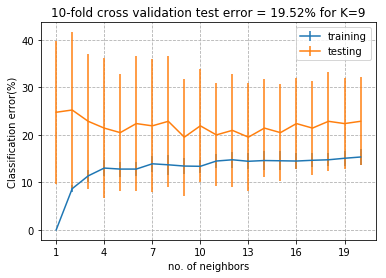

In [51]:
plt.errorbar(range(1, 1+max_neighbors), train_errors_mean, train_errors_std)
plt.errorbar(range(1, 1+max_neighbors), test_errors_mean, test_errors_std)
plt.legend(['training', 'testing'])
plt.xlabel('no. of neighbors')
plt.ylabel('Classification error(%)')
plt.xticks(range(1, 1+max_neighbors, 3))
plt.grid(linestyle='--')
s = '10-fold cross validation test error = ' + r'%.2f%%' % min(test_errors_mean) + ' for K='+ \
    str(1+np.argmin(test_errors_mean))
plt.title(s)
#plt.savefig('p2_errorVsNeighbors_crossValid.jpg', dpi=300)
plt.show()

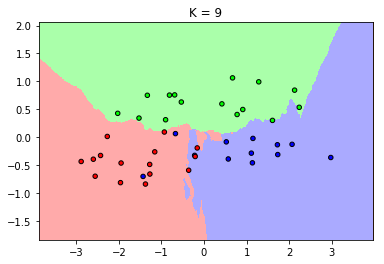

In [33]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors

n_neighbors = 9
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(X_train_pca, y_train)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# Plot also the training points
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('K = %d' % (n_neighbors))

#plt.savefig('p2_KNN_visualize.jpg', dpi=300)
plt.show()

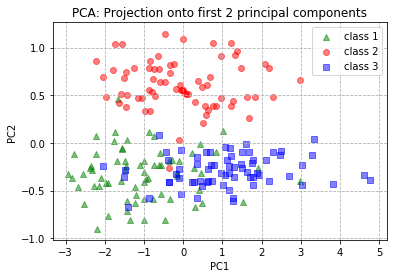

In [121]:
################### Dimension Reduction #######################
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X)
X_pca = pca.transform(X)

for label,marker,color in zip(range(1,4),('^', 'o', 's'),('green', 'red', 'blue')):
    plt.scatter(x=X_pca[:,0].real[y == label],
                y=X_pca[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Projection onto first 2 principal components')
plt.legend(['class 1', 'class 2', 'class 3'])
plt.grid(linestyle='--')
#plt.savefig('p2_unsupervised_PCA_vis.jpg', dpi=300)
plt.show()

In [116]:
############## K-center ###############
def kcenter(no_clusters, X):
    N, p = X.shape

    # Cluster to which points in X_train belong
    cluster = np.zeros((N, ), dtype = int)
    # distance of points from the cluster center
    dist = np.zeros((N, ))

    L = lambda x_j, h_i: np.sqrt(np.sum((x_j - h_i)**2))

    # Initializing cluster center
    H = X_pca[4] # h1 first samples without loss of generality

    for j in range(N):
        x_j = X[j]
        h_i = H[0]
        cluster[j] = 0
        dist[j] = L(x_j, h_i)

    for i in range(1,no_clusters):
        for idx in np.argsort(dist)[::-1]:
            if X[idx] in H:
                continue
            else:
                h_i = X[idx]
                H = np.vstack((H, h_i))
                break
        for j in range(N):
            x_j = X[j]
            if L(x_j, h_i) <= dist[j]:
                cluster[j] = i
                dist[j] = L(x_j, h_i)
    return cluster, H

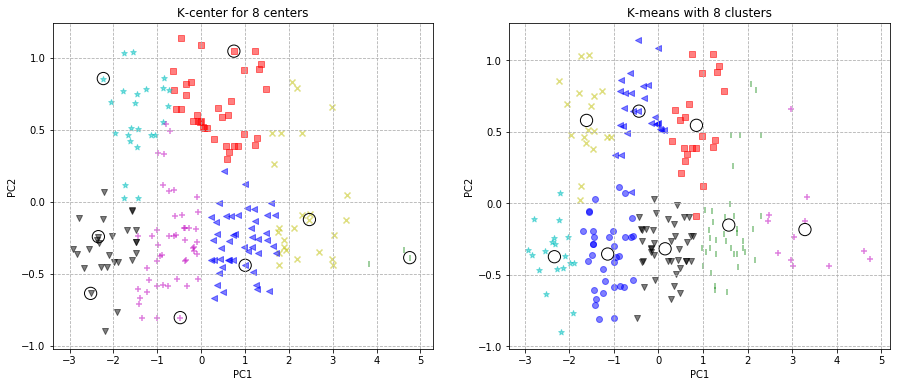

In [142]:
from sklearn.cluster import KMeans
K = 8
kmeans = KMeans(n_clusters=K, random_state=0, max_iter=1000).fit(X_pca)
kmeans_cluster, kmeans_centers = kmeans.labels_, kmeans.cluster_centers_
kcenter_cluster, kcenter_centers = kcenter(K, X_pca)

markers = ['o', '|', 's', '*', '+', 'x', 'v', '<', '.', ',', '>', '8', '_', '^']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
for i in range(K):
    plt.scatter(x = X_pca[:, 0].real[kcenter_cluster == i],
                y = X_pca[:, 1].real[kcenter_cluster == i],
                marker = markers[i],
                color = colors[i],
                alpha = 0.5)
for h in kcenter_centers:
    plt.scatter(h[0], h[1], s = 150, facecolors = 'none', edgecolors = 'k')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(linestyle='--')
plt.title('K-center for %d centers' % (K))

plt.subplot(1, 2, 2)
for i in range(K):
    plt.scatter(x = X_pca[:, 0].real[kmeans_cluster == i],
                y = X_pca[:, 1].real[kmeans_cluster == i],
                marker = markers[i],
                color = colors[i],
                alpha = 0.5)

for h in kmeans_centers:
    plt.scatter(h[0], h[1], s = 150, facecolors = 'none', edgecolors = 'k')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(linestyle='--')
plt.title('K-means with %d clusters' % (K))
plt.savefig('p2_kcenter_vs_kmeans_%d_clusters.jpg' % (K), dpi=300)
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors

n_neighbors = 9
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(X_train_pca, y_train)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# Plot also the training points
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('K = %d' % (n_neighbors))
#plt.savefig('p2_KNN_visualize.jpg', dpi=300)
plt.show()